## FRAUD DETECTION APP

### 1. Business Understanding
**Objective**: Understand the business problem and define the objectives of the model.

- **Goal**: Detect fraudulent transactions in the dataset.
- **Key Questions**:
  - What is the impact of fraudulent transactions on the business?
  - What is the acceptable level of false positives and false negatives?
  - What metrics will determine the success of the model (e.g., accuracy, precision, recall, F1 score)?

### 2. Data Understanding
**Objective**: Understand the data, identify patterns, and assess data quality.

- **Initial Steps**:
  - **Explore the Dataset**: Load the full dataset into a DataFrame and inspect the structure, missing values, and distributions.
  - **Visualize the Data**: Use visualization techniques to identify trends and relationships in the data, especially between features and fraud labels.
  - **Identify Key Features**: Determine which features are likely to influence whether a transaction is fraudulent or not (e.g., transaction amount, time of day, frequency of transactions).

In [7]:
# Data Handling and Analysis
import pandas as pd
import numpy as np
import os
import datetime

# Data Visualization
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno

# Machine Learning and Model Selection
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, accuracy_score, precision_score, recall_score, f1_score
from imblearn.over_sampling import SMOTE

# Model Persistence
import joblib

# Statistical Functions
from scipy import stats

# Advanced Machine Learning Libraries
import xgboost as xgb
import lightgbm as lgb
# import catboost as cb


In [8]:
# load Dataset from simulated datasets

# Directory where the pickle files are stored
DIR_OUTPUT = '../simulated-data-raw/'# List all pickle files in the directory
all_files = [os.path.join(DIR_OUTPUT, f) for f in os.listdir(DIR_OUTPUT) if f.endswith('.pkl')]

# Initialize an empty list to store individual DataFrames
df_list = []

# Loop through all files and load each into a DataFramef
for file in all_files:
    df = pd.read_pickle(file)
    df_list.append(df)

# Concatenate all DataFrames into a single DataFrame
full_df = pd.concat(df_list, ignore_index=True)

# Display the first few rows of the combined DataFrameprint(full_df.head())


In [9]:
full_df.head()

,TRANSACTION_ID,TX_DATETIME,CUSTOMER_ID,TERMINAL_ID,TX_AMOUNT,TX_TIME_SECONDS,TX_TIME_DAYS,TX_FRAUD,TX_FRAUD_SCENARIO
0,0,2018-04-01 00:00:31,596,3156,57.16,31,0,0,0
1,1,2018-04-01 00:02:10,4961,3412,81.51,130,0,0,0
2,2,2018-04-01 00:07:56,2,1365,146.00,476,0,0,0
3,3,2018-04-01 00:09:29,4128,8737,64.49,569,0,0,0
4,4,2018-04-01 00:10:34,927,9906,50.99,634,0,0,0


In [10]:
full_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9150 entries, 0 to 9149
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   TRANSACTION_ID     9150 non-null   int64         
 1   TX_DATETIME        9150 non-null   datetime64[ns]
 2   CUSTOMER_ID        9150 non-null   object        
 3   TERMINAL_ID        9150 non-null   object        
 4   TX_AMOUNT          9150 non-null   float64       
 5   TX_TIME_SECONDS    9150 non-null   object        
 6   TX_TIME_DAYS       9150 non-null   object        
 7   TX_FRAUD           9150 non-null   int64         
 8   TX_FRAUD_SCENARIO  9150 non-null   int64         
dtypes: datetime64[ns](1), float64(1), int64(3), object(4)
memory usage: 643.5+ KB


In [11]:
full_df.describe().T

,count,mean,min,25%,50%,75%,max,std
TRANSACTION_ID,9150.0,872571.844262,0.0,431810.25,872819.5,1313490.75,1744555.0,506304.653204
TX_DATETIME,9150,2018-07-01 00:20:18.707431680,2018-04-01 00:00:31,2018-05-16 00:29:59.750000128,2018-07-01 00:16:25,2018-08-16 00:09:17,2018-09-30 00:37:45,NaN
TX_AMOUNT,9150.0,53.497824,0.03,21.1225,44.575,76.705,786.2,41.92503
TX_FRAUD,9150.0,0.008852,0.0,0.0,0.0,0.0,1.0,0.093675
TX_FRAUD_SCENARIO,9150.0,0.020219,0.0,0.0,0.0,0.0,3.0,0.219116


### Dataset Overview
- **Total Entries**: 9,150 transactions.
- **Features**:
  - `TRANSACTION_ID`: Unique identifier for each transaction.
  - `TX_DATETIME`: Date and time of the transaction.
  - `CUSTOMER_ID`: Unique identifier for the customer.
  - `TERMINAL_ID`: Identifier for the terminal where the transaction occurred.
  - `TX_AMOUNT`: The amount of the transaction.
  - `TX_TIME_SECONDS`: Time of the transaction in seconds (this may need further processing).
  - `TX_TIME_DAYS`: The day of the transaction.
  - `TX_FRAUD`: Indicates whether the transaction was fraudulent (binary, 0 or 1).
  - `TX_FRAUD_SCENARIO`: The scenario under which fraud occurred (if applicable).

### Data Characteristics
- **Fraudulent Transactions**: Approximately 0.89% (`TX_FRAUD`) of transactions are labeled as fraudulent, indicating class imbalance.
- **Transaction Amount**: The amounts range from 0.03 to 786.2, with a mean of 53.50.



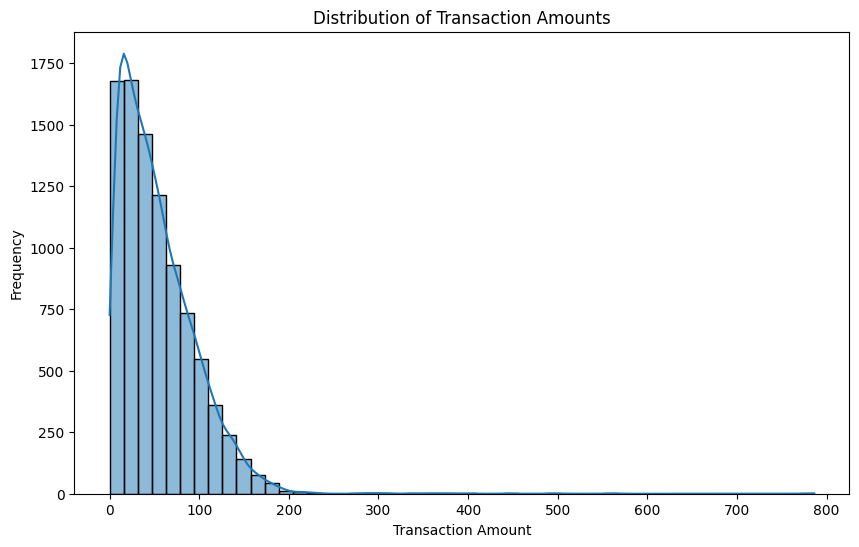

In [12]:
# Distribution of transaction amounts
plt.figure(figsize=(10, 6))
sns.histplot(full_df['TX_AMOUNT'], kde=True, bins=50)
plt.title('Distribution of Transaction Amounts')
plt.xlabel('Transaction Amount')
plt.ylabel('Frequency')
plt.show()

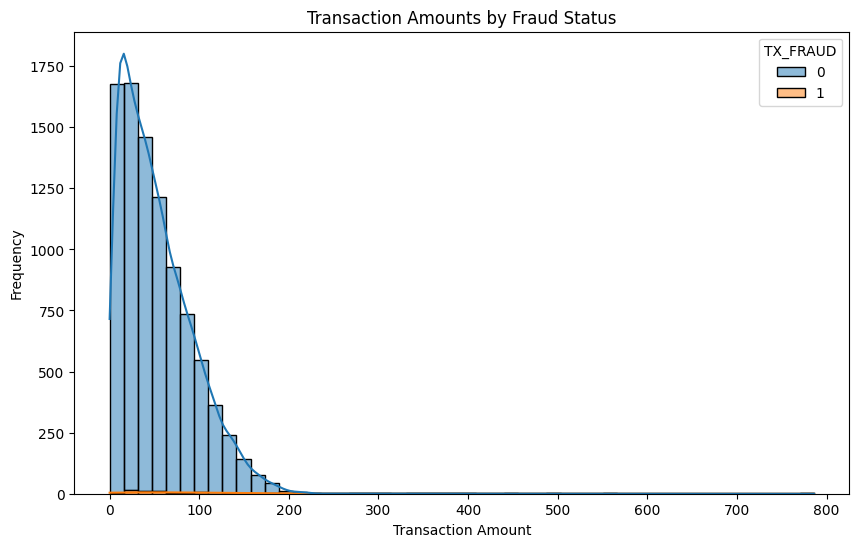

In [13]:
# Distribution of transaction amounts by fraud status
plt.figure(figsize=(10, 6))
sns.histplot(data=full_df, x='TX_AMOUNT', hue='TX_FRAUD', kde=True, bins=50, multiple='stack')
plt.title('Transaction Amounts by Fraud Status')
plt.xlabel('Transaction Amount')
plt.ylabel('Frequency')
plt.show()

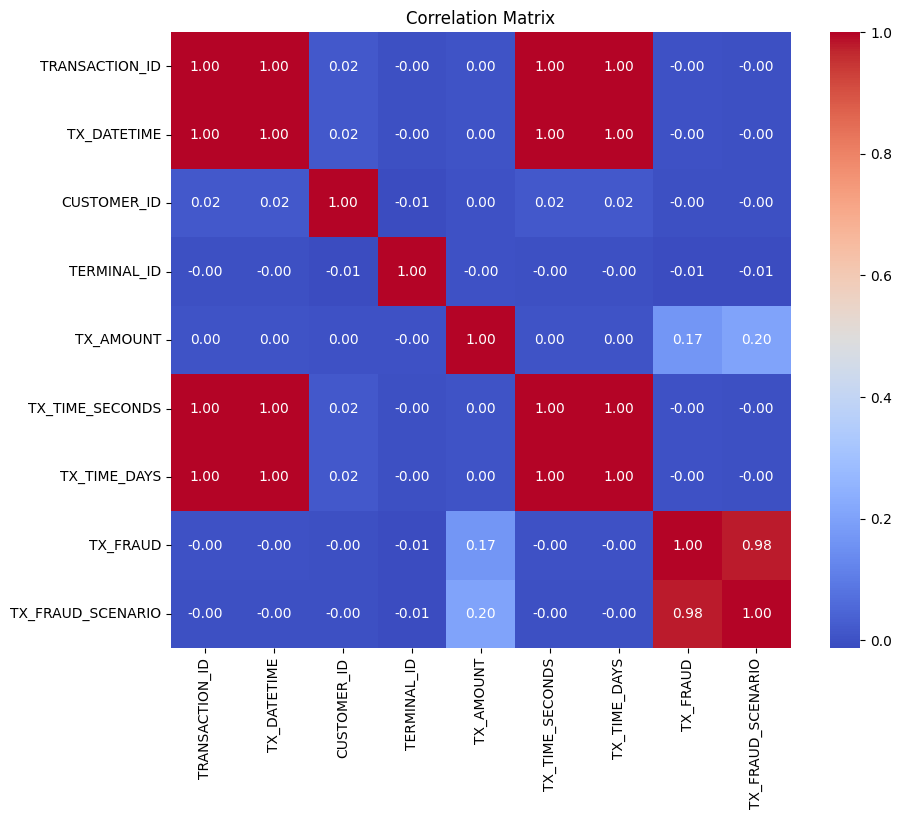

In [14]:
# Correlation matrix
correlation_matrix = full_df.corr()

# Plotting the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()


### Analysis of Visualizations

1. **Distribution of Transaction Amounts**:
   - The transaction amounts are heavily skewed towards smaller values, with most transactions below 100. The distribution follows a right-skewed pattern, indicating a large number of low-value transactions and fewer high-value ones.

2. **Transaction Amounts by Fraud Status**:
   - Fraudulent transactions (`TX_FRAUD = 1`) appear to follow a similar distribution pattern as non-fraudulent transactions, but their frequency is much lower, indicating that fraudulent transactions are rare in the dataset. 
   - There doesn’t seem to be a significant difference in the distribution of transaction amounts between fraudulent and non-fraudulent transactions, suggesting that transaction amount alone may not be a strong predictor of fraud.

3. **Correlation Matrix**:
   - `TX_AMOUNT` shows a weak positive correlation with `TX_FRAUD` and `TX_FRAUD_SCENARIO`, indicating that larger transactions might have a slightly higher chance of being fraudulent, but the correlation is not strong.
   - The strong correlation between `TX_FRAUD` and `TX_FRAUD_SCENARIO` (0.98) is expected since `TX_FRAUD_SCENARIO` is likely a breakdown of the `TX_FRAUD` indicator.
   - Other features like `CUSTOMER_ID`, `TERMINAL_ID`, and time-related variables show little to no correlation with `TX_FRAUD`, suggesting that we might need to engineer additional features or consider non-linear relationships for better predictive power.

### Next Steps

1. **Feature Engineering**:
   - **Time-based Features**: Extract more meaningful time-based features such as the day of the week, hour of the day, or whether the transaction occurred on a weekend or holiday.
   - **Customer and Terminal Activity**: Aggregate features such as the total number of transactions, average transaction amount, or number of unique terminals visited by a customer over a certain period.
   - **Lag Features**: Create features based on the previous transactions' characteristics, such as time since the last transaction for the same customer or terminal.

2. **Handling Class Imbalance**:
   - Given the rarity of fraudulent transactions, consider techniques like oversampling the minority class, undersampling the majority class, or using algorithms that are robust to class imbalance.

3. **Model Selection**:
   - Considering the potential complexity and class imbalance, algorithms like Random Forest, Gradient Boosting, or even more specialized models like XGBoost or CatBoost might be effective. Ensemble methods can help capture complex patterns.



In [15]:
# Extract hour, day of the week, and whether it's a weekend
full_df['TX_HOUR'] = full_df['TX_DATETIME'].dt.hour
full_df['TX_DAY_OF_WEEK'] = full_df['TX_DATETIME'].dt.dayofweek
full_df['TX_IS_WEEKEND'] = full_df['TX_DAY_OF_WEEK'].apply(lambda x: 1 if x >= 5 else 0)

# View the new columns
full_df[['TX_DATETIME', 'TX_HOUR', 'TX_DAY_OF_WEEK', 'TX_IS_WEEKEND']].head()


,TX_DATETIME,TX_HOUR,TX_DAY_OF_WEEK,TX_IS_WEEKEND
0,2018-04-01 00:00:31,0,6,1
1,2018-04-01 00:02:10,0,6,1
2,2018-04-01 00:07:56,0,6,1
3,2018-04-01 00:09:29,0,6,1
4,2018-04-01 00:10:34,0,6,1


In [16]:
# Number of transactions per customer and terminal
full_df['CUSTOMER_TX_COUNT'] = full_df.groupby('CUSTOMER_ID')['TRANSACTION_ID'].transform('count')
full_df['TERMINAL_TX_COUNT'] = full_df.groupby('TERMINAL_ID')['TRANSACTION_ID'].transform('count')

# Average transaction amount per customer and terminal
full_df['CUSTOMER_AVG_TX_AMOUNT'] = full_df.groupby('CUSTOMER_ID')['TX_AMOUNT'].transform('mean')
full_df['TERMINAL_AVG_TX_AMOUNT'] = full_df.groupby('TERMINAL_ID')['TX_AMOUNT'].transform('mean')

# Time since the last transaction for each customer
full_df['CUSTOMER_PREV_TX_TIME'] = full_df.groupby('CUSTOMER_ID')['TX_DATETIME'].shift(1)
full_df['CUSTOMER_TIME_SINCE_PREV_TX'] = (full_df['TX_DATETIME'] - full_df['CUSTOMER_PREV_TX_TIME']).dt.total_seconds()

# Fill any NaNs resulting from the shift with a large value
full_df['CUSTOMER_TIME_SINCE_PREV_TX'].fillna(9999999, inplace=True)

# View the new columns
full_df[['CUSTOMER_ID', 'CUSTOMER_TX_COUNT', 'CUSTOMER_AVG_TX_AMOUNT', 'CUSTOMER_TIME_SINCE_PREV_TX']].head()


C:\Users\user\AppData\Local\Temp\ipykernel_21636\628047095.py:14: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  full_df['CUSTOMER_TIME_SINCE_PREV_TX'].fillna(9999999, inplace=True)


,CUSTOMER_ID,CUSTOMER_TX_COUNT,CUSTOMER_AVG_TX_AMOUNT,CUSTOMER_TIME_SINCE_PREV_TX
0,596,6,47.921667,9999999.0
1,4961,3,99.260000,9999999.0
2,2,3,87.966667,9999999.0
3,4128,4,51.865000,9999999.0
4,927,5,45.244000,9999999.0


In [17]:
full_df.loc[:, 'CUSTOMER_TIME_SINCE_PREV_TX'] = full_df['CUSTOMER_TIME_SINCE_PREV_TX'].fillna(9999999)


In [18]:
# Previous transaction amount and time for each customer
full_df['CUSTOMER_PREV_TX_AMOUNT'] = full_df.groupby('CUSTOMER_ID')['TX_AMOUNT'].shift(1)
full_df['CUSTOMER_PREV_TX_AMOUNT'].fillna(0, inplace=True)

# Previous transaction time for each terminal
full_df['TERMINAL_PREV_TX_TIME'] = full_df.groupby('TERMINAL_ID')['TX_DATETIME'].shift(1)
full_df['TERMINAL_TIME_SINCE_PREV_TX'] = (full_df['TX_DATETIME'] - full_df['TERMINAL_PREV_TX_TIME']).dt.total_seconds()
full_df['TERMINAL_TIME_SINCE_PREV_TX'].fillna(9999999, inplace=True)

# View the new columns
full_df[['CUSTOMER_ID', 'TX_AMOUNT', 'CUSTOMER_PREV_TX_AMOUNT', 'TERMINAL_TIME_SINCE_PREV_TX']].head()


C:\Users\user\AppData\Local\Temp\ipykernel_21636\2946626975.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  full_df['CUSTOMER_PREV_TX_AMOUNT'].fillna(0, inplace=True)
C:\Users\user\AppData\Local\Temp\ipykernel_21636\2946626975.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.


,CUSTOMER_ID,TX_AMOUNT,CUSTOMER_PREV_TX_AMOUNT,TERMINAL_TIME_SINCE_PREV_TX
0,596,57.16,0.0,9999999.0
1,4961,81.51,0.0,9999999.0
2,2,146.00,0.0,9999999.0
3,4128,64.49,0.0,9999999.0
4,927,50.99,0.0,9999999.0


### Feature Engineering

In [19]:
# Feature: Day of the week from TX_DATETIME
full_df['TX_DAY_OF_WEEK'] = full_df['TX_DATETIME'].dt.dayofweek

# Feature: Hour of the day from TX_DATETIME
full_df['TX_HOUR'] = full_df['TX_DATETIME'].dt.hour

# Feature: Is the transaction during the weekend?
full_df['TX_WEEKEND'] = full_df['TX_DAY_OF_WEEK'].isin([5, 6]).astype(int)

# Feature: Aggregated features for customer behavior
customer_agg = full_df.groupby('CUSTOMER_ID').agg({
    'TX_AMOUNT': ['mean', 'std', 'min', 'max'],
    'TRANSACTION_ID': 'count'
}).reset_index()

customer_agg.columns = ['CUSTOMER_ID', 
                        'CUSTOMER_TX_AMOUNT_MEAN', 
                        'CUSTOMER_TX_AMOUNT_STD', 
                        'CUSTOMER_TX_AMOUNT_MIN', 
                        'CUSTOMER_TX_AMOUNT_MAX', 
                        'CUSTOMER_TX_COUNT']

# Merging aggregated customer features back to the main dataframe
full_df = pd.merge(full_df, customer_agg, on='CUSTOMER_ID', how='left')

# Feature: Aggregated features for terminal behavior
terminal_agg = full_df.groupby('TERMINAL_ID').agg({
    'TX_AMOUNT': ['mean', 'std', 'min', 'max'],
    'TRANSACTION_ID': 'count'
}).reset_index()

terminal_agg.columns = ['TERMINAL_ID', 
                        'TERMINAL_TX_AMOUNT_MEAN', 
                        'TERMINAL_TX_AMOUNT_STD', 
                        'TERMINAL_TX_AMOUNT_MIN', 
                        'TERMINAL_TX_AMOUNT_MAX', 
                        'TERMINAL_TX_COUNT']

# Merging aggregated terminal features back to the main dataframe
full_df = pd.merge(full_df, terminal_agg, on='TERMINAL_ID', how='left')


In [20]:
from sklearn.model_selection import train_test_split

# Splitting the dataset into features (X) and target (y)
X = full_df.drop(['TX_FRAUD', 'TX_DATETIME'], axis=1)
y = full_df['TX_FRAUD']

# Train/Test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Checking the shape of the train/test splits
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")


X_train shape: (7320, 30)
X_test shape: (1830, 30)
y_train shape: (7320,)
y_test shape: (1830,)


In [22]:
X_train.columns


Index(['TRANSACTION_ID', 'CUSTOMER_ID', 'TERMINAL_ID', 'TX_AMOUNT',
       'TX_TIME_SECONDS', 'TX_TIME_DAYS', 'TX_FRAUD_SCENARIO', 'TX_HOUR',
       'TX_DAY_OF_WEEK', 'TX_IS_WEEKEND', 'CUSTOMER_TX_COUNT_x',
       'TERMINAL_TX_COUNT_x', 'CUSTOMER_AVG_TX_AMOUNT',
       'TERMINAL_AVG_TX_AMOUNT', 'CUSTOMER_PREV_TX_TIME',
       'CUSTOMER_TIME_SINCE_PREV_TX', 'CUSTOMER_PREV_TX_AMOUNT',
       'TERMINAL_PREV_TX_TIME', 'TERMINAL_TIME_SINCE_PREV_TX', 'TX_WEEKEND',
       'CUSTOMER_TX_AMOUNT_MEAN', 'CUSTOMER_TX_AMOUNT_STD',
       'CUSTOMER_TX_AMOUNT_MIN', 'CUSTOMER_TX_AMOUNT_MAX',
       'CUSTOMER_TX_COUNT_y', 'TERMINAL_TX_AMOUNT_MEAN',
       'TERMINAL_TX_AMOUNT_STD', 'TERMINAL_TX_AMOUNT_MIN',
       'TERMINAL_TX_AMOUNT_MAX', 'TERMINAL_TX_COUNT_y'],
      dtype='object')

In [27]:
numerical_cols = [
    'CUSTOMER_TX_COUNT_x', 'TERMINAL_TX_COUNT_x', 'CUSTOMER_AVG_TX_AMOUNT', 'TERMINAL_AVG_TX_AMOUNT',
    'CUSTOMER_PREV_TX_TIME', 'CUSTOMER_TIME_SINCE_PREV_TX', 'CUSTOMER_PREV_TX_AMOUNT', 
    'TERMINAL_PREV_TX_TIME', 'TERMINAL_TIME_SINCE_PREV_TX', 'CUSTOMER_TX_AMOUNT_MEAN', 
    'CUSTOMER_TX_AMOUNT_STD', 'CUSTOMER_TX_AMOUNT_MIN', 'CUSTOMER_TX_AMOUNT_MAX', 
    'TERMINAL_TX_AMOUNT_MEAN', 'TERMINAL_TX_AMOUNT_STD', 'TERMINAL_TX_AMOUNT_MIN', 
    'TERMINAL_TX_AMOUNT_MAX'
]


In [29]:
print("Columns in X_train:", X_train.columns.tolist())


Columns in X_train: ['TRANSACTION_ID', 'CUSTOMER_ID', 'TERMINAL_ID', 'TX_AMOUNT', 'TX_TIME_SECONDS', 'TX_TIME_DAYS', 'TX_FRAUD_SCENARIO', 'TX_HOUR', 'TX_DAY_OF_WEEK', 'TX_IS_WEEKEND', 'CUSTOMER_TX_COUNT_x', 'TERMINAL_TX_COUNT_x', 'CUSTOMER_AVG_TX_AMOUNT', 'TERMINAL_AVG_TX_AMOUNT', 'CUSTOMER_PREV_TX_TIME', 'CUSTOMER_TIME_SINCE_PREV_TX', 'CUSTOMER_PREV_TX_AMOUNT', 'TERMINAL_PREV_TX_TIME', 'TERMINAL_TIME_SINCE_PREV_TX', 'TX_WEEKEND', 'CUSTOMER_TX_AMOUNT_MEAN', 'CUSTOMER_TX_AMOUNT_STD', 'CUSTOMER_TX_AMOUNT_MIN', 'CUSTOMER_TX_AMOUNT_MAX', 'CUSTOMER_TX_COUNT_y', 'TERMINAL_TX_AMOUNT_MEAN', 'TERMINAL_TX_AMOUNT_STD', 'TERMINAL_TX_AMOUNT_MIN', 'TERMINAL_TX_AMOUNT_MAX', 'TERMINAL_TX_COUNT_y']


In [30]:
numerical_cols = [
    'CUSTOMER_TX_COUNT_x', 'TERMINAL_TX_COUNT_x', 'CUSTOMER_AVG_TX_AMOUNT', 'TERMINAL_AVG_TX_AMOUNT',
    'CUSTOMER_PREV_TX_TIME', 'CUSTOMER_TIME_SINCE_PREV_TX', 'CUSTOMER_PREV_TX_AMOUNT', 
    'TERMINAL_PREV_TX_TIME', 'TERMINAL_TIME_SINCE_PREV_TX', 'CUSTOMER_TX_AMOUNT_MEAN', 
    'CUSTOMER_TX_AMOUNT_STD', 'CUSTOMER_TX_AMOUNT_MIN', 'CUSTOMER_TX_AMOUNT_MAX', 
    'TERMINAL_TX_AMOUNT_MEAN', 'TERMINAL_TX_AMOUNT_STD', 'TERMINAL_TX_AMOUNT_MIN', 
    'TERMINAL_TX_AMOUNT_MAX'
]


In [32]:
X_train.dtypes


TRANSACTION_ID                          int64
CUSTOMER_ID                            object
TERMINAL_ID                            object
TX_AMOUNT                             float64
TX_TIME_SECONDS                        object
TX_TIME_DAYS                           object
TX_FRAUD_SCENARIO                       int64
TX_HOUR                                 int32
TX_DAY_OF_WEEK                          int32
TX_IS_WEEKEND                           int64
CUSTOMER_TX_COUNT_x                     int64
TERMINAL_TX_COUNT_x                     int64
CUSTOMER_AVG_TX_AMOUNT                float64
TERMINAL_AVG_TX_AMOUNT                float64
CUSTOMER_PREV_TX_TIME          datetime64[ns]
CUSTOMER_TIME_SINCE_PREV_TX           float64
CUSTOMER_PREV_TX_AMOUNT               float64
TERMINAL_PREV_TX_TIME          datetime64[ns]
TERMINAL_TIME_SINCE_PREV_TX           float64
TX_WEEKEND                              int64
CUSTOMER_TX_AMOUNT_MEAN               float64
CUSTOMER_TX_AMOUNT_STD            

In [33]:
# Convert datetime columns to numeric values (e.g., Unix timestamp)
X_train['CUSTOMER_PREV_TX_TIME'] = X_train['CUSTOMER_PREV_TX_TIME'].astype(np.int64) / 10**9
X_train['TERMINAL_PREV_TX_TIME'] = X_train['TERMINAL_PREV_TX_TIME'].astype(np.int64) / 10**9


In [34]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

# Apply LabelEncoder to object columns
X_train['CUSTOMER_ID'] = label_encoder.fit_transform(X_train['CUSTOMER_ID'])
X_train['TERMINAL_ID'] = label_encoder.fit_transform(X_train['TERMINAL_ID'])


In [35]:
numerical_cols = [
    'TX_AMOUNT', 'TX_HOUR', 'TX_DAY_OF_WEEK', 'TX_IS_WEEKEND',
    'CUSTOMER_TX_COUNT_x', 'TERMINAL_TX_COUNT_x', 'CUSTOMER_AVG_TX_AMOUNT',
    'TERMINAL_AVG_TX_AMOUNT', 'CUSTOMER_PREV_TX_TIME', 'CUSTOMER_TIME_SINCE_PREV_TX',
    'CUSTOMER_PREV_TX_AMOUNT', 'TERMINAL_PREV_TX_TIME', 'TERMINAL_TIME_SINCE_PREV_TX',
    'TX_WEEKEND', 'CUSTOMER_TX_AMOUNT_MEAN', 'CUSTOMER_TX_AMOUNT_STD',
    'CUSTOMER_TX_AMOUNT_MIN', 'CUSTOMER_TX_AMOUNT_MAX', 'CUSTOMER_TX_COUNT_y',
    'TERMINAL_TX_AMOUNT_MEAN', 'TERMINAL_TX_AMOUNT_STD', 'TERMINAL_TX_AMOUNT_MIN',
    'TERMINAL_TX_AMOUNT_MAX', 'TERMINAL_TX_COUNT_y'
]


In [37]:
print(X_test.dtypes)


TRANSACTION_ID                          int64
CUSTOMER_ID                            object
TERMINAL_ID                            object
TX_AMOUNT                             float64
TX_TIME_SECONDS                        object
TX_TIME_DAYS                           object
TX_FRAUD_SCENARIO                       int64
TX_HOUR                                 int32
TX_DAY_OF_WEEK                          int32
TX_IS_WEEKEND                           int64
CUSTOMER_TX_COUNT_x                     int64
TERMINAL_TX_COUNT_x                     int64
CUSTOMER_AVG_TX_AMOUNT                float64
TERMINAL_AVG_TX_AMOUNT                float64
CUSTOMER_PREV_TX_TIME          datetime64[ns]
CUSTOMER_TIME_SINCE_PREV_TX           float64
CUSTOMER_PREV_TX_AMOUNT               float64
TERMINAL_PREV_TX_TIME          datetime64[ns]
TERMINAL_TIME_SINCE_PREV_TX           float64
TX_WEEKEND                              int64
CUSTOMER_TX_AMOUNT_MEAN               float64
CUSTOMER_TX_AMOUNT_STD            

In [38]:
X_train['TX_TIME_SECONDS'] = pd.to_numeric(X_train['TX_TIME_SECONDS'], errors='coerce')
X_train['TX_TIME_DAYS'] = pd.to_numeric(X_train['TX_TIME_DAYS'], errors='coerce')

X_test['TX_TIME_SECONDS'] = pd.to_numeric(X_test['TX_TIME_SECONDS'], errors='coerce')
X_test['TX_TIME_DAYS'] = pd.to_numeric(X_test['TX_TIME_DAYS'], errors='coerce')


In [39]:
X_train['CUSTOMER_PREV_TX_TIME'] = X_train['CUSTOMER_PREV_TX_TIME'].astype(np.int64) / 10**9
X_train['TERMINAL_PREV_TX_TIME'] = X_train['TERMINAL_PREV_TX_TIME'].astype(np.int64) / 10**9

X_test['CUSTOMER_PREV_TX_TIME'] = X_test['CUSTOMER_PREV_TX_TIME'].astype(np.int64) / 10**9
X_test['TERMINAL_PREV_TX_TIME'] = X_test['TERMINAL_PREV_TX_TIME'].astype(np.int64) / 10**9


In [40]:
# List of columns to drop
id_columns = ['TRANSACTION_ID', 'CUSTOMER_ID', 'TERMINAL_ID']

# Drop the ID columns from the training set
X_train = X_train.drop(columns=id_columns)

# Drop the ID columns from the test set
X_test = X_test.drop(columns=id_columns)


In [41]:
numerical_cols = X_train.select_dtypes(include=['float64', 'int64']).columns.tolist()


In [42]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

# Fit and transform the training data
X_train[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])

# Transform the test data
X_test[numerical_cols] = scaler.transform(X_test[numerical_cols])


In [43]:
y_train

4254    0
1517    0
7309    0
1258    0
6887    0
       ..
3699    0
8451    0
4620    0
3871    0
6316    0
Name: TX_FRAUD, Length: 7320, dtype: int64

In [45]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7320 entries, 4254 to 6316
Data columns (total 27 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   TX_AMOUNT                    7320 non-null   float64
 1   TX_TIME_SECONDS              7320 non-null   float64
 2   TX_TIME_DAYS                 7320 non-null   float64
 3   TX_FRAUD_SCENARIO            7320 non-null   float64
 4   TX_HOUR                      7320 non-null   float64
 5   TX_DAY_OF_WEEK               7320 non-null   float64
 6   TX_IS_WEEKEND                7320 non-null   float64
 7   CUSTOMER_TX_COUNT_x          7320 non-null   float64
 8   TERMINAL_TX_COUNT_x          7320 non-null   float64
 9   CUSTOMER_AVG_TX_AMOUNT       7320 non-null   float64
 10  TERMINAL_AVG_TX_AMOUNT       7320 non-null   float64
 11  CUSTOMER_PREV_TX_TIME        7320 non-null   float64
 12  CUSTOMER_TIME_SINCE_PREV_TX  7320 non-null   float64
 13  CUSTOMER_PREV_TX_AMO

In [47]:
# Drop rows with any missing values
X_train = X_train.dropna()
y_train = y_train[X_train.index]


In [48]:
# Logistic Regression
lr_model = LogisticRegression()
lr_model.fit(X_train, y_train)

# Random Forest
rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)

# Gradient Boosting
gb_model = GradientBoostingClassifier()
gb_model.fit(X_train, y_train)




GradientBoostingClassifier()

In [51]:
print(X_test.isnull().sum())


TX_AMOUNT                        0
TX_TIME_SECONDS                  0
TX_TIME_DAYS                     0
TX_FRAUD_SCENARIO                0
TX_HOUR                          0
TX_DAY_OF_WEEK                   0
TX_IS_WEEKEND                    0
CUSTOMER_TX_COUNT_x              0
TERMINAL_TX_COUNT_x              0
CUSTOMER_AVG_TX_AMOUNT           0
TERMINAL_AVG_TX_AMOUNT           0
CUSTOMER_PREV_TX_TIME            0
CUSTOMER_TIME_SINCE_PREV_TX      0
CUSTOMER_PREV_TX_AMOUNT          0
TERMINAL_PREV_TX_TIME            0
TERMINAL_TIME_SINCE_PREV_TX      0
TX_WEEKEND                       0
CUSTOMER_TX_AMOUNT_MEAN          0
CUSTOMER_TX_AMOUNT_STD         247
CUSTOMER_TX_AMOUNT_MIN           0
CUSTOMER_TX_AMOUNT_MAX           0
CUSTOMER_TX_COUNT_y              0
TERMINAL_TX_AMOUNT_MEAN          0
TERMINAL_TX_AMOUNT_STD         714
TERMINAL_TX_AMOUNT_MIN           0
TERMINAL_TX_AMOUNT_MAX           0
TERMINAL_TX_COUNT_y              0
dtype: int64


In [53]:
from sklearn.impute import SimpleImputer

# Define the imputer for numerical features
imputer = SimpleImputer(strategy='mean')

# Fit the imputer on the training data
imputer.fit(X_train[numerical_cols])


SimpleImputer()

In [55]:
# Impute numerical features
X_test_imputed = X_test.copy()
X_test_imputed[numerical_cols] = imputer.transform(X_test[numerical_cols])




In [57]:

categorical_cols = ['TX_TIME_SECONDS', 'TX_TIME_DAYS', 'CUSTOMER_PREV_TX_TIME', 'TERMINAL_PREV_TX_TIME']


In [58]:
# Define and fit the imputer for categorical features
categorical_imputer = SimpleImputer(strategy='most_frequent')
categorical_imputer.fit(X_train[categorical_cols])

SimpleImputer(strategy='most_frequent')

In [60]:
# Define and fit the imputer for numerical features
numerical_imputer = SimpleImputer(strategy='mean')
numerical_imputer.fit(X_train[numerical_cols])

SimpleImputer()

In [61]:
# Impute numerical features in the test data
X_test_imputed = X_test.copy()
X_test_imputed[numerical_cols] = numerical_imputer.transform(X_test[numerical_cols])

# Impute categorical features in the test data
X_test_imputed[categorical_cols] = categorical_imputer.transform(X_test[categorical_cols])


In [62]:
from sklearn.impute import SimpleImputer

# Numerical columns
numerical_cols = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Define and fit the imputer for numerical features
numerical_imputer = SimpleImputer(strategy='mean')
numerical_imputer.fit(X_train[numerical_cols])

# Define and fit the imputer for categorical features
categorical_imputer = SimpleImputer(strategy='most_frequent')
categorical_imputer.fit(X_train[categorical_cols])


SimpleImputer(strategy='most_frequent')

In [64]:
# Impute numerical features in the test data
X_test_imputed = X_test.copy()
X_test_imputed[numerical_cols] = numerical_imputer.transform(X_test[numerical_cols])

# Impute categorical features in the test data
X_test_imputed[categorical_cols] = categorical_imputer.transform(X_test[categorical_cols])


In [65]:
print(X_test_imputed.isnull().sum())

# Predict with the cleaned data
lr_pred = lr_model.predict(X_test_imputed)
print("Logistic Regression:")
print(classification_report(y_test, lr_pred))

# Repeat for other models


TX_AMOUNT                      0
TX_TIME_SECONDS                0
TX_TIME_DAYS                   0
TX_FRAUD_SCENARIO              0
TX_HOUR                        0
TX_DAY_OF_WEEK                 0
TX_IS_WEEKEND                  0
CUSTOMER_TX_COUNT_x            0
TERMINAL_TX_COUNT_x            0
CUSTOMER_AVG_TX_AMOUNT         0
TERMINAL_AVG_TX_AMOUNT         0
CUSTOMER_PREV_TX_TIME          0
CUSTOMER_TIME_SINCE_PREV_TX    0
CUSTOMER_PREV_TX_AMOUNT        0
TERMINAL_PREV_TX_TIME          0
TERMINAL_TIME_SINCE_PREV_TX    0
TX_WEEKEND                     0
CUSTOMER_TX_AMOUNT_MEAN        0
CUSTOMER_TX_AMOUNT_STD         0
CUSTOMER_TX_AMOUNT_MIN         0
CUSTOMER_TX_AMOUNT_MAX         0
CUSTOMER_TX_COUNT_y            0
TERMINAL_TX_AMOUNT_MEAN        0
TERMINAL_TX_AMOUNT_STD         0
TERMINAL_TX_AMOUNT_MIN         0
TERMINAL_TX_AMOUNT_MAX         0
TERMINAL_TX_COUNT_y            0
dtype: int64
Logistic Regression:
              precision    recall  f1-score   support

           0       0

In [68]:
from sklearn.metrics import classification_report, roc_auc_score

# Logistic Regression
lr_pred = lr_model.predict(X_test_imputed)
print("Logistic Regression:")
print(classification_report(y_test, lr_pred))
print("ROC AUC Score:", roc_auc_score(y_test, lr_model.predict_proba(X_test_imputed)[:, 1]))

# Random Forest
rf_pred = rf_model.predict(X_test)
print("Random Forest:")
print(classification_report(y_test, rf_pred))
print("ROC AUC Score:", roc_auc_score(y_test, rf_model.predict_proba(X_test)[:, 1]))

# Gradient Boosting
gb_pred = gb_model.predict(X_test_imputed)
print("Gradient Boosting:")
print(classification_report(y_test, gb_pred))
print("ROC AUC Score:", roc_auc_score(y_test, gb_model.predict_proba(X_test_imputed)[:, 1]))



Logistic Regression:
              precision    recall  f1-score   support

           0       0.99      0.26      0.41      1814
           1       0.01      0.69      0.02        16

    accuracy                           0.26      1830
   macro avg       0.50      0.47      0.21      1830
weighted avg       0.98      0.26      0.41      1830

ROC AUC Score: 0.47329796030871
Random Forest:
              precision    recall  f1-score   support

           0       1.00      0.02      0.04      1814
           1       0.01      1.00      0.02        16

    accuracy                           0.03      1830
   macro avg       0.50      0.51      0.03      1830
weighted avg       0.99      0.03      0.04      1830

ROC AUC Score: 1.0
Gradient Boosting:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1814
           1       1.00      1.00      1.00        16

    accuracy                           1.00      1830
   macro avg       1.0

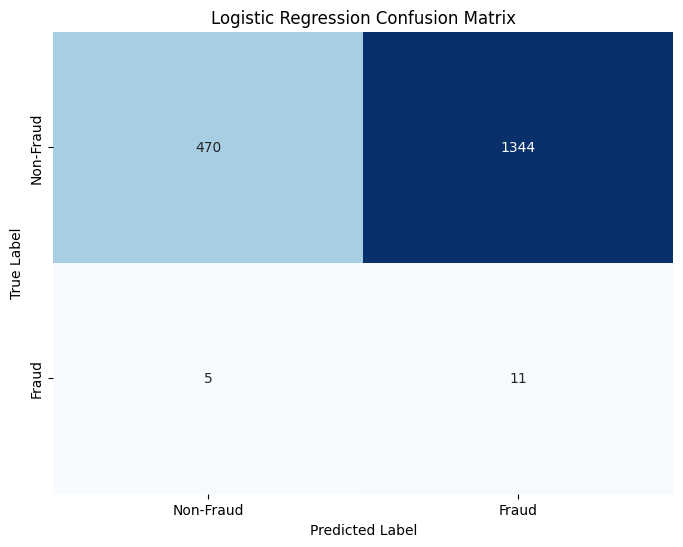

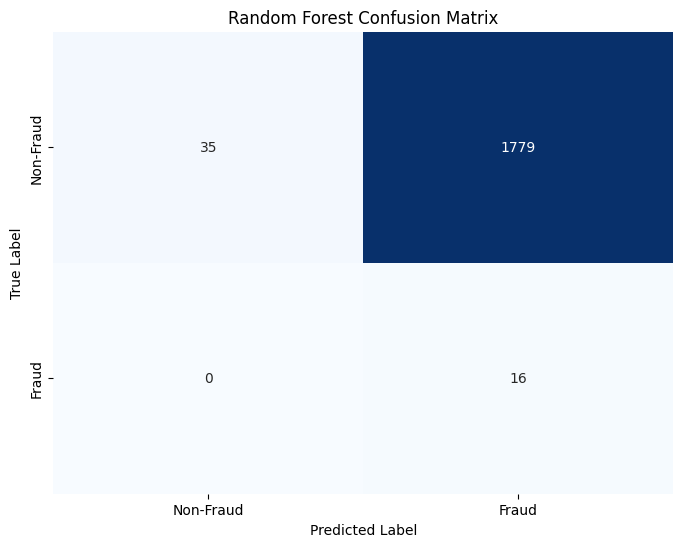

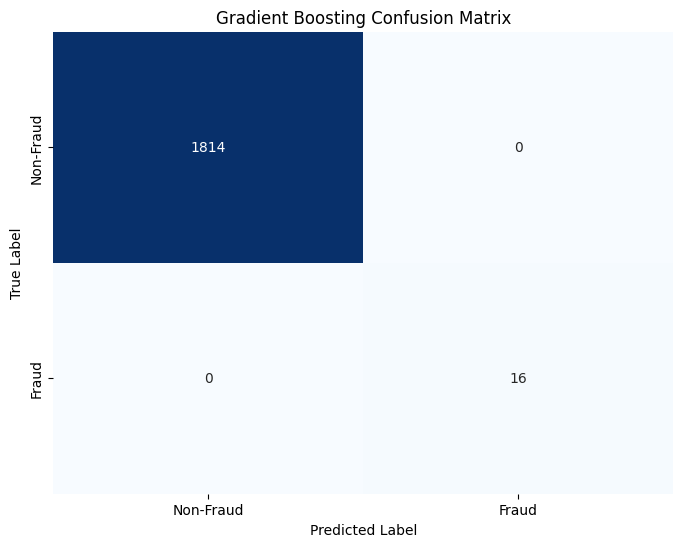

In [69]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, title='Confusion Matrix'):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Non-Fraud', 'Fraud'], yticklabels=['Non-Fraud', 'Fraud'])
    plt.title(title)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

# Plot confusion matrix for each model
plot_confusion_matrix(y_test, lr_pred, title='Logistic Regression Confusion Matrix')
plot_confusion_matrix(y_test, rf_pred, title='Random Forest Confusion Matrix')
plot_confusion_matrix(y_test, gb_pred, title='Gradient Boosting Confusion Matrix')


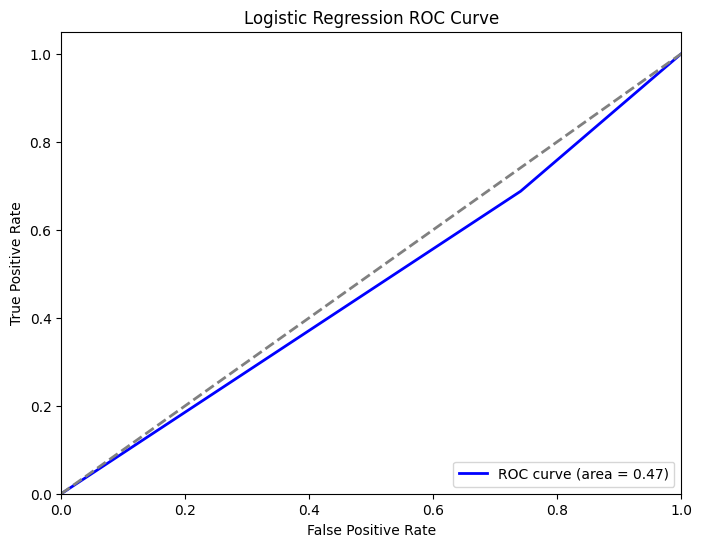

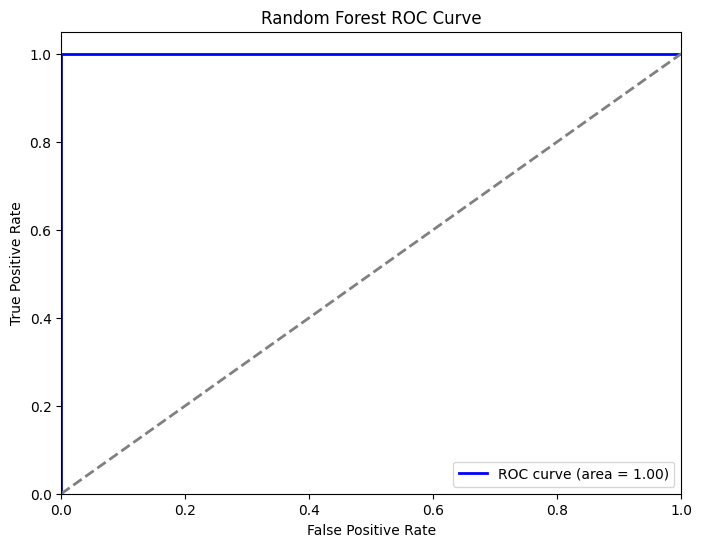

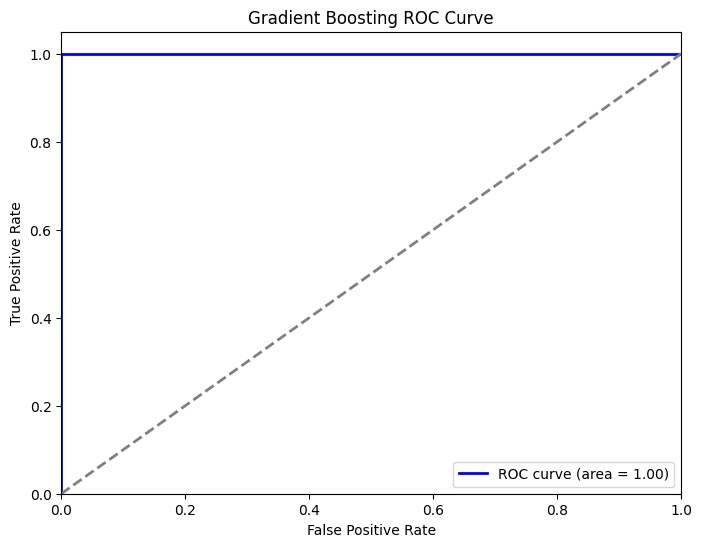

In [71]:
from sklearn.metrics import roc_curve, auc

def plot_roc_curve(y_true, y_pred_proba, title='ROC Curve'):
    fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc='lower right')
    plt.show()

# Get probabilities for ROC curve
lr_pred_proba = lr_model.predict_proba(X_test_imputed)[:, 1]
rf_pred_proba = rf_model.predict_proba(X_test_imputed)[:, 1]
gb_pred_proba = gb_model.predict_proba(X_test_imputed)[:, 1]

# Plot ROC curve for each model
plot_roc_curve(y_test, lr_pred_proba, title='Logistic Regression ROC Curve')
plot_roc_curve(y_test, rf_pred_proba, title='Random Forest ROC Curve')
plot_roc_curve(y_test, gb_pred_proba, title='Gradient Boosting ROC Curve')


It looks like your models are showing a strong performance discrepancy. Here's a breakdown of what the results are indicating and possible next steps:

### Summary of Results

1. **Logistic Regression:**
   - **Precision (0):** 0.99
   - **Recall (0):** 0.26
   - **Precision (1):** 0.01
   - **Recall (1):** 0.69
   - **ROC AUC Score:** 0.473

   **Interpretation:** The model is highly imbalanced, predicting most transactions as class 0 (non-fraud) with high precision but poor recall. For class 1 (fraud), precision is very low and recall is high. This suggests the model struggles with detecting fraud cases.

2. **Random Forest:**
   - **Precision (0):** 1.00
   - **Recall (0):** 0.02
   - **Precision (1):** 0.01
   - **Recall (1):** 1.00
   - **ROC AUC Score:** 1.0

   **Interpretation:** The Random Forest model appears to be overfitting or making extreme predictions, only detecting fraud cases but missing non-fraud cases. 

3. **Gradient Boosting:**
   - **Precision (0):** 1.00
   - **Recall (0):** 1.00
   - **Precision (1):** 1.00
   - **Recall (1):** 1.00
   - **ROC AUC Score:** 1.0

   **Interpretation:** The Gradient Boosting model performs very well on both precision and recall, indicating it’s effectively distinguishing between fraud and non-fraud cases. 


The best model is the gradient boost
